In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


In [60]:
def read_csv(file):
    #čitanje csva
    df = pd.read_csv(file,usecols=['id','time'], parse_dates=['time'], encoding='latin1')
    #print(df)
    return df

In [61]:
def get_limits(month, year):
    end=pd.to_datetime("{}-{}-01 23:59:59".format(year,month+1))-pd.Timedelta(days=1)
    beginning=pd.to_datetime("{}-{}-01 00:00:00".format(year,month))
    #print(end,beginning)
    return end, beginning

In [62]:
def calculate_diff(df, column, beginning, end):
    #oduzimanje susjednih redaka
    df['diff']=df[column].diff(periods=1)    
     #izračun razmaka između poč. mjeseca i prvog mjerenja
    df.loc[0,'diff']=df.loc[0, column] - beginning
    #izračun razmaka između kraja mjeseca i zadnjeg mjerenja
    df.loc[len(df)] = {'diff':end - df.loc[len(df)-1, column], column: end}

In [73]:
def filter_rows(step,df):
    df['index'] = range(len(df))
    df2=df[df['diff'] > step]
    #filtiranje samo redaka čiji je diff veci od odabranog step-a (i njihovih prethodnika)
    previous_row = df2['index'] - 1
    result = pd.concat([df[df['index'].isin(previous_row) ], df2])
    result.sort_index(inplace=True, ignore_index=True)
    print(result)
    return result

In [64]:
def make_table(result, beginning):
    if result.loc[0,'index']==0:
        #prvi red ima rupu od poč. mjeseca tj prvi snimljeni trenutak je upao u trenutke s rupom
        new_df=pd.DataFrame({'start-time':[beginning], 'end-time':[result.loc[0,'time']], 'duration':[result.loc[0,'diff']]})
        new_df=pd.concat([new_df,pd.DataFrame({
        'start-time': result['time'].iloc[1::2].reset_index(drop=True),
        'end-time': result['time'].iloc[2::2].reset_index(drop=True),
        'duration': result['diff'].iloc[2::2].reset_index(drop=True)
        })], ignore_index=True)
    else:
        #nema rupe od poč. mjeseca, uzimam parove redaka
        new_df = pd.DataFrame({
            'start-time': result['time'].iloc[0::2].reset_index(drop=True),
            'end-time': result['time'].iloc[1::2].reset_index(drop=True),
            'duration': result['diff'].iloc[1::2].reset_index(drop=True)
        })
        return new_df

In [71]:
def obrada(month, year, step):
    #step definira koja je granica za rupu
    df = read_csv("bojler\{}\{}_{}.csv".format(year,month,year))
    end, beginning = get_limits(month, year)
    #nijedan podatak nije zabiljezen u mjesecu
    if df.empty:
        df=pd.DataFrame({'start-time':[beginning], 'end-time':[end], 'duration':[end-beginning]})
        return df
    #izračun rupa između mjerenja
    calculate_diff(df,'time', beginning, end)
    #print(df)
    #filtriranje rupa vecih od stepa
    result = filter_rows(step,df)
    if(result.empty):
        print("nema rupa")
        return result
    #formiranje tablice u obliku start - end - duration
    final_result = make_table(result, beginning)
    return final_result

end=pd.to_datetime("2022-{}-01 23:59:59".format(month+1))-pd.Timedelta(days=1)
beginning=pd.to_datetime("2022-{}-01 00:00:00".format(month))
all_timestamps = pd.date_range(start=beginning, end=end, freq='120S')


is_within_interval_list = [
    any((timestamp >= row['time1']) and (timestamp <= row['time2']) for i, row in df.iterrows())
    for timestamp in all_timestamps
]

plt.plot(all_timestamps, is_within_interval_list)
tick_positions = pd.date_range(start=beginning, end=end, freq='1D')
plt.xticks(tick_positions, [timestamp.strftime('%Y-%m-%d') for timestamp in tick_positions], rotation=45, ha='right', fontsize=8)
plt.xticks(rotation=45, ha='right', fontsize=8)  

plt.xlabel('Timestamp', fontsize=10) 
plt.ylabel('Is within interval (1 or 0)')
plt.title('Scatter Plots of Timestamps within Intervals for the Entire Month')

fig = plt.gcf()
fig.set_size_inches(20, 6)  # Adjust the width and height as needed
plt.savefig('responsive_plot.png', dpi=300, bbox_inches='tight')

plt.show()

In [66]:
def generate_all_timestamps(beginning, end, frequency):
    all_timestamps = pd.date_range(start=beginning, end=end, freq=frequency)
    return all_timestamps

In [67]:
def check_holes(all_timestamps, df):
    is_within_interval_list = [
        any((timestamp >= row['start-time']) and (timestamp <= row['end-time']) for i, row in df.iterrows())
        for timestamp in all_timestamps
    ]
    return is_within_interval_list
    

In [68]:
def create_graph(all_timestamps, beginning, end, month, interval_list):
    fig, ax = plt.subplots() 
    ax.plot(all_timestamps, interval_list, linewidth=1)
    tick_positions = pd.date_range(start=beginning, end=end, freq='1D')
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([timestamp.strftime('%Y-%m-%d') for timestamp in tick_positions], rotation=45, ha='right', fontsize=8)
    
    ax.set_xlabel('Timestamp', fontsize=10)
    ax.set_ylabel('1 - rupa, 0 - zapis')
    ax.set_title("Graf rupa u podacima većih od {} za {}. mjesec".format(step, month))
    
    fig.set_size_inches(20, 6)  # Adjust the width and height as needed
    plt.savefig("{}m_graph.png".format(month), dpi=600, bbox_inches='tight')
    return

In [69]:
def make_graph(month,year, step):
    df=obrada(month,year,step)
    print("{}. mjesec".format(month))
    end, beginning = get_limits(month, year)
    #generiranje svih 'trenutaka' u mjesecu kad bi podaci trebali biti upisani
    all_timestamps = generate_all_timestamps(beginning, end, '30S')
    #true za trenutke koji su u rupi, false za one koji nisu
    
    interval_list = check_holes(all_timestamps, df)
    percentage = interval_list.count(True)/len(interval_list)*100
    print("Postotak rupa: {} %".format(round(percentage,2)))
    #stvaranje grafa
    create_graph(all_timestamps, beginning, end, month, interval_list)
    #plt.show()
    return

            id                time            diff    index
0  331389865.0 2023-07-13 07:02:24 0 days 00:00:02   510510
1  331389890.0 2023-07-14 15:48:08 1 days 08:45:44   510511
2  335268265.0 2023-07-18 09:34:11 0 days 00:00:03   665646
3  335268290.0 2023-07-18 13:16:31 0 days 03:42:20   665647
4  336428290.0 2023-07-19 16:07:15 0 days 00:00:02   712047
5  336428315.0 2023-07-20 18:45:39 1 days 02:38:24   712048
6  347046140.0 2023-07-30 23:59:59 0 days 00:00:02  1136761
7          NaN 2023-07-31 23:59:59 1 days 00:00:00  1136762
7. mjesec
Postotak rupa: 11.71 %


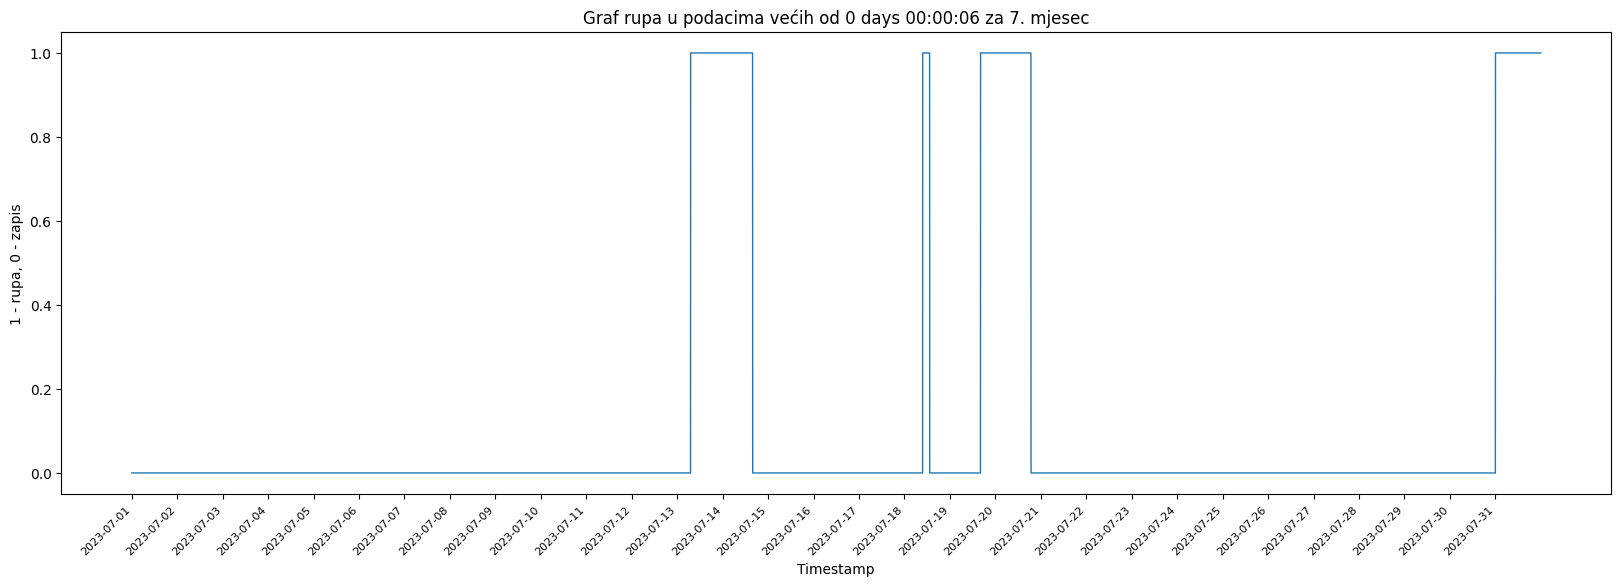

In [74]:
step=pd.to_timedelta('00:00:06')
make_graph(7,2023,step)
#for i in range(4,12):
 #  make_graph(i, step)